In [1]:
import copy
import pickle
import datetime

import numpy as np
from scipy import constants as cst

import matplotlib.pyplot as plt
import tqdm
from labellines import labelLine, labelLines

from centrex_tlf import states, hamiltonian, transitions, couplings, lindblad, utils
from centrex_tlf_julia_extension import lindblad_julia

c:\Users\ogras\anaconda3\envs\centrex-tlf\lib\site-packages\julia\juliainfo.py:93: UserWarning: julia warned:
The latest version of Julia in the `release` channel is 1.10.5+0.x64.w64.mingw32. You currently have `1.10.4+0.x64.w64.mingw32` installed. Run:

  juliaup update

in your terminal shell to install Julia 1.10.5+0.x64.w64.mingw32 and update the `release` channel to that version.
  warnings.warn("{} warned:\n{}".format(julia, stderr))


In [2]:
plt.rcParams.update({"font.size": 15})

In [3]:
trans = [
    transitions.OpticalTransition(
        transitions.OpticalTransitionType.P, J_ground=2, F1=3 / 2, F=1
    ),
    transitions.MicrowaveTransition(
        J_ground=2,
        J_excited=1,
        electronic_ground=states.ElectronicState.X,
        electronic_excited=states.ElectronicState.X,
    ),
    transitions.MicrowaveTransition(
        J_ground=2,
        J_excited=3,
        electronic_ground=states.ElectronicState.X,
        electronic_excited=states.ElectronicState.X,
    ),
]

polarizations = [
    [couplings.polarization_Z, couplings.polarization_X],
    [couplings.polarization_X, couplings.polarization_Y],
    [couplings.polarization_σm, couplings.polarization_σp],
]

transition_selectors = couplings.generate_transition_selectors(
    trans,
    polarizations,
)

In [4]:
obe_system = lindblad.setup_OBE_system_transitions(
    trans,
    transition_selectors,
    verbose=True,
    qn_compact=None,
    decay_channels=None,
    Jmax_X=4,
)

INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 1/5 -> Generating the reduced Hamiltonian


INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 2/5 -> Generating the couplings corresponding to the transitions
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 3/5 -> Generating the symbolic Hamiltonian
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 4/5 -> Generating the collapse matrices
INFO:centrex_tlf.lindblad.utils_setup:generate_OBE_system: 5/5 -> Transforming the Hamiltonian and collapse matrices into a symbolic system of equations


In [5]:
v_to_Γ = utils.detuning.velocity_to_detuning(1)
v_to_Γ_μ = 0

odepars = lindblad_julia.odeParameters(
    Ω0=1 * hamiltonian.Γ,
    δ0=f"vx*{v_to_Γ}",  # detuning of the laser [rad/s]
    P0="sin(ω0*t + φ0)",
    PZ0="P0>0",
    PX0="P0<=0",
    ω0=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ0=0.0,  # polarization switching phase [rad]
    # J=1 -> J=2 microwaves
    Ω1=1 * hamiltonian.Γ,
    δ1=f"vx*{v_to_Γ_μ}",
    P1="sin(ω1*t + φ1)",
    PX1="P1>0",
    PY1="P1<=0",
    ω1=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ1=2 * np.pi / 3,  # polarization switching phase [rad]
    # J=2 -> J=3 microwaves
    Ω2=hamiltonian.Γ,
    # Ω2=0.1 * hamiltonian.Γ,
    δ2=f"vx*{v_to_Γ_μ}",
    P2="sin(ω2*t + φ2)",
    Pσm2="P2>0",
    Pσp2="P2<=0",
    ω2=2 * np.pi * 1e6,  # polarization switching frequency [rad/s]
    φ2=4 * np.pi / 3,  # polarization switching phase [rad]
    vx=0.0,
)

In [6]:
# on my home pc julia only loads on the third try, use try except in while loop to
# automatically retry
import logging

counter = 0
while True:
    try:
        obe_system = lindblad_julia.setup_OBE_system_julia(
            obe_system, transition_selectors, odepars, n_procs=5
        )
    except Exception:
        counter += 1
        logging.warning(f"Catch exception {counter}")
        if counter > 3:
            break
        continue
    break


In [7]:
couplings.generate_br_dataframe(obe_system.ground, obe_system.excited, group_ground="J")

,"|B, J = 1, F₁ = 3/2, F = 1>"
states,
"|X, J = 0>",0.484131
"|X, J = 2>",0.515869


In [8]:
indices_J0 = states.QuantumSelector(
    J=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1 = states.QuantumSelector(
    J=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2 = states.QuantumSelector(
    J=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3 = states.QuantumSelector(
    J=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_excited = states.QuantumSelector(
    electronic=states.ElectronicState.B
).get_indices(obe_system.QN)
indices_J0_F0 = states.QuantumSelector(
    J=0, F=0, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J0_F1 = states.QuantumSelector(
    J=0, F=1, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J1_F2 = states.QuantumSelector(
    J=1, F=2, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J2_F3 = states.QuantumSelector(
    J=2, F=3, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)
indices_J3_F4 = states.QuantumSelector(
    J=3, F=4, electronic=states.ElectronicState.X
).get_indices(obe_system.QN)

In [9]:
ρ = utils.population.generate_thermal_population_states(6.3, obe_system.QN)
ρ /= np.trace(ρ)

In [10]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 1.6 * 25.4e-3 / 184))
config = lindblad_julia.OBEProblemConfig(
    saveat=1e-6,
    reltol=1e-3,
    abstol=1e-7,
    save_everystep=True,
)

In [11]:
results = lindblad_julia.do_simulation_single(problem, config=config)

29.382508899106682


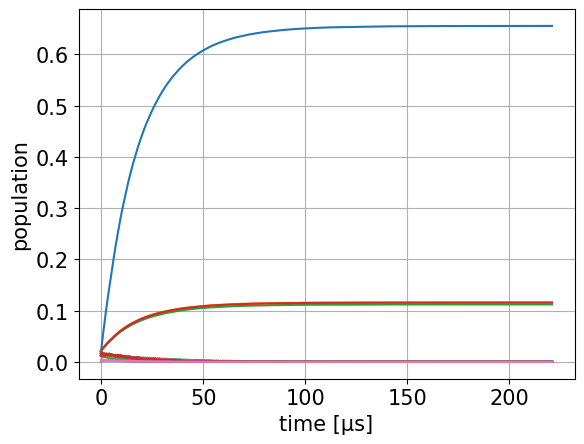

In [12]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y.T)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

print(results.y[0, -1] / results.y[0, 0])

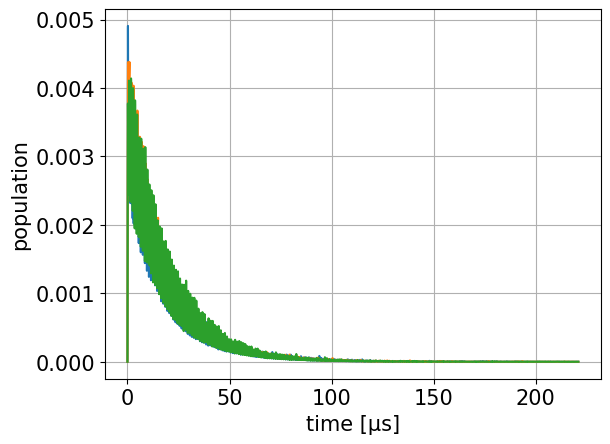

In [13]:
fig, ax = plt.subplots()
ax.plot(results.t * 1e6, results.y[indices_excited].T)

ax.set_xlabel("time [μs]")
ax.set_ylabel("population")

ax.grid()

# Parameter Scan rabi rates and laser frequency only

In [ ]:
odepars.ω1 = 2 * np.pi * 1e6
odepars.ϕ1 = 2 * np.pi / 3
odepars.ω2 = 2 * np.pi * 1e6
odepars.ϕ2 = 4 * np.pi / 3


In [14]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

rabis0 = np.logspace(-2, np.log10(5), 11) * hamiltonian.Γ
rabis1 = np.logspace(-2, np.log10(5), 11) * hamiltonian.Γ
rabis2 = np.logspace(-2, np.log10(5), 11) * hamiltonian.Γ
pol_freqs = np.linspace(0, 2, 9) * 2 * np.pi * 1e6

In [15]:
sim_time = datetime.datetime.now().replace(microsecond=0).isoformat().replace(":", "-")

In [70]:
from julia import Main

output_func = f"""
@everywhere function output_func(sol, i)
    open("output_{sim_time}.csv", "a") do file
        println(file, repr(append!([Float64(i)], real(last(sol)))))
    end
    real(last(sol)), false
end
"""
Main.eval(output_func)
output_func_name = "output_func"

In [17]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_everystep=False,
    save_idxs=save_idxs,
    reltol=1e-3,
    abstol=1e-7,
)


problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 210e-6))

scan_values = [rabis0, rabis1, rabis2, pol_freqs]
parameters = ["Ω0", "Ω1", "Ω2", "ω0"]

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func_name,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)

In [18]:
%%time
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)

CPU times: total: 37.8 s
Wall time: 4h 50min 7s


In [54]:
dat = np.array(Main.eval("sol.u[:]"))
with open(f"output_{sim_time}_final.csv", "w") as f:
    for idl, line in enumerate(dat):
        v = str([idl + 1] + [v.item() for v in list(line)])
        f.write(f"{v[1:-1]}\n")
del dat


In [81]:
with open(f"params_{sim_time}.csv", "w") as f:
    f.write(",".join(parameters) + "\n")
    for line in Main.params:
        f.write(",".join([str(v) for v in line]) + "\n")

with open(f"config_{sim_time}.txt", "w") as f:
    f.write(str(odepars) + "\n\n")
    f.write(str(ensemble_config) + "\n\n")
    f.write(f"tspan={ensemble_problem.problem.tspan}\n")
    f.write(output_func)
    f.write("\n")

with open(f"function_{sim_time}.jl", "w") as f:
    f.write(obe_system.preamble)
    for line in obe_system.code_lines:
        f.write("\t\t" + line + "\n")
    f.write("\t end \n \t nothing \n end")

with open(f"simulation_{sim_time}.pkl", "wb") as f:
    pickle.dump(
        {
            "obe_system": obe_system,
            "problem": problem,
            "ensemble_config": ensemble_config,
            "ensemble_problem": ensemble_problem,
            "scan_values": scan_values,
            "parameters": parameters,
        },
        f,
    )

In [85]:
from julia import Main

_trajectories = np.prod([len(v) for v in ensemble_problem.scan_values])
res = np.array([Main.eval(f"sol.u[{idx+1}]") for idx in range(_trajectories)])
res = res.reshape(
    [len(v) for v in ensemble_problem.scan_values][::-1] + [res.shape[-1]]
).T

results_scan = lindblad_julia.OBEResultParameterScan(
    parameters=ensemble_problem.parameters,
    scan_values=np.meshgrid(*ensemble_problem.scan_values, indexing="ij"),
    results=res,
    zipped=False,
)

In [86]:
dat = results_scan.results[0].copy()

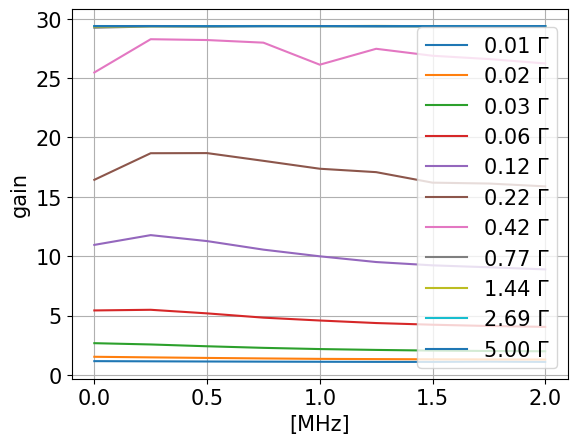

In [116]:
X, Y, Z, W = results_scan.scan_values

fig, ax = plt.subplots()
for idx in range(len(rabis0)):
    slice = np.s_[idx, idx, idx, :]
    ax.plot(
        W[slice] / (2 * np.pi * 1e6),
        dat[slice] / ρ[0, 0].real,
        label=f"{rabis0[idx]/hamiltonian.Γ:.2f} Γ",
    )

ax.set_xlabel("[MHz]")
ax.set_ylabel("gain")
ax.legend()
ax.grid()


# Parameter scan rabi rates, no laser pol switching and microwave pol frequencies

In [140]:
odepars.ω0 = 0.0
odepars.ϕ1 = 0.0
odepars.ϕ2 = np.pi / 2


In [141]:
save_idxs = utils.population.get_diagonal_indices_flattened(
    size=len(obe_system.QN), mode="julia"
)

rabis0 = np.logspace(-2, np.log10(5), 11) * hamiltonian.Γ
rabis1 = np.logspace(-2, np.log10(5), 11) * hamiltonian.Γ
rabis2 = np.logspace(-2, np.log10(5), 11) * hamiltonian.Γ
pol_freqs = np.linspace(0, 2, 9) * 2 * np.pi * 1e6


In [142]:
sim_time = datetime.datetime.now().replace(microsecond=0).isoformat().replace(":", "-")

In [144]:
from julia import Main

output_func = f"""
@everywhere function output_func(sol, i)
    open("output_{sim_time}.csv", "a") do file
        println(file, repr(append!([Float64(i)], real(last(sol)))))
    end
    real(last(sol)), false
end
"""
Main.eval(output_func)
output_func_name = "output_func"


In [146]:
ensemble_config = lindblad_julia.OBEEnsembleProblemConfig(
    method="Tsit5()",
    save_everystep=False,
    save_idxs=save_idxs,
    reltol=1e-3,
    abstol=1e-7,
)


problem = lindblad_julia.OBEProblem(odepars, ρ, tspan=(0, 210e-6))

scan_values = [rabis0, rabis1, rabis2, pol_freqs]
scan_values = np.array(np.meshgrid(*scan_values, indexing="ij")).T.reshape(
    -1, len(scan_values)
)
scan_values = [scan_values[:, idx] for idx in range(scan_values.shape[-1])]
scan_values += [scan_values[-1]]

parameters = ["Ω0", "Ω1", "Ω2", "ω1", "ω2"]

ensemble_problem = lindblad_julia.OBEEnsembleProblem(
    problem=problem,
    parameters=parameters,
    scan_values=scan_values,
    output_func=output_func_name,
    zipped=True,
)

lindblad_julia.setup_problem_parameter_scan(
    ensemble_problem,
)


In [147]:
%%time
lindblad_julia.solve_problem_parameter_scan(ensemble_problem, ensemble_config)


CPU times: total: 46.4 s
Wall time: 6h 34min 25s


In [148]:
dat = np.array(Main.eval("sol.u[:]"))
with open(f"output_{sim_time}_final.csv", "w") as f:
    for idl, line in enumerate(dat):
        v = str([idl + 1] + [v.item() for v in list(line)])
        f.write(f"{v[1:-1]}\n")
del dat


In [149]:
with open(f"params_{sim_time}.csv", "w") as f:
    f.write(",".join(parameters) + "\n")
    for line in Main.params:
        f.write(",".join([str(v) for v in line]) + "\n")

with open(f"config_{sim_time}.txt", "w") as f:
    f.write(str(odepars) + "\n\n")
    f.write(str(ensemble_config) + "\n\n")
    f.write(f"tspan={ensemble_problem.problem.tspan}\n")
    f.write(output_func)
    f.write("\n")

with open(f"function_{sim_time}.jl", "w") as f:
    f.write(obe_system.preamble)
    for line in obe_system.code_lines:
        f.write("\t\t" + line + "\n")
    f.write("\t end \n \t nothing \n end")

with open(f"simulation_{sim_time}.pkl", "wb") as f:
    pickle.dump(
        {
            "obe_system": obe_system,
            "problem": problem,
            "ensemble_config": ensemble_config,
            "ensemble_problem": ensemble_problem,
            "scan_values": scan_values,
            "parameters": parameters,
        },
        f,
    )
